# Time series plotting around reservoirs

## To-dos
- [x] point_subset functions to codebase
- [x] time series metrics to function

In [2]:
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(func_dir)
import load_data
import time_series_calcs
import plotting_functions
import area_subsets

In [13]:
fw_DA = load_data.load_CYGNSS_05()
grace_dict = load_data.load_GRACE()
res_shp = load_data.load_GRanD()
precip_DA = load_data.load_IMERG()

In [23]:
def single_timeseries_IMERG_CYGNSS_GRACE(coords_i,**plot_params):
    """
    Description
    -----------
    Hard-coded time series slicing for IMERG and CYGNSS to start two months after the intersecting_timeframes() start date
    
    Inputs
    ------
    coords_i: tuple of (lat,lon)
    **plot_params : dict
        dictionary of plot formatting options and labels
            Keys used: None, all passed to `three_part_timeseries`
    
    Outputs
    -------
    precip , fw , cmwe : Pandas Series
        Series used for plotting
        Respectively, precipitation, fractional water, TWS
    """
    global precip_DA , fw_DA , grace_dict
    precip_full = area_subsets.precip_point_subset(coords_i,precip_DA)
    fw_full = area_subsets.cygnss_point_subset(coords_i,fw_DA)
    cmwe_full , mascon_ts = area_subsets.grace_point_subset(coords_i,grace_dict)

    precip , fw , cmwe = time_series_calcs.intersecting_timeframes(precip_full,fw_full,cmwe_full,buffer=0)
    precip = precip[2:]
    fw = fw[2:]
    
    plot_params['data_labels'] = ['IMERG','CYGNSS','GRACE']
    plot_params['x_label'] = 'Time'
    plot_params['y_labels'] = ['Precip (mm/hr)', 'Fraction of surface water coverage', 'TWS water equivalence (cm)']
    plot_params['line_fmt'] = ['c-','b-','k-']
    plot_params['figsize'] = (12,6)

    plotting_functions.three_part_timeseries([precip , fw , cmwe],**plot_params)
    
    return precip , fw , cmwe

In [5]:
res_coords_dict = {
    'merowe' : (18.68 , 32.06),
    'indirasagar' : (22.18,76.6),
    'estreito' : (-6.50001 ,-47.0)
}

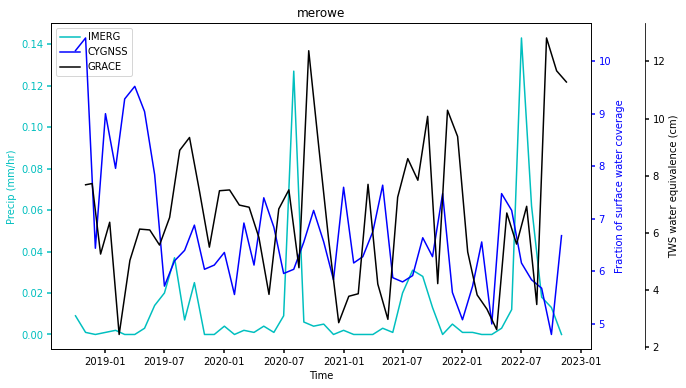

In [63]:
res_oi = 'merowe'
plot_params = {
    'title' : res_oi
}
precip_series , fw_series , cmwe_series = single_timeseries_IMERG_CYGNSS_GRACE(area_subsets.reservoir_name_to_point(res_oi,res_shp),**plot_params)

In [106]:
def series_to_TSM_object(input_series,*TSM_args,**TSM_kwargs):
    series_obj = input_series.astype(float)
    series_obj.index = list(map(time_series_calcs.toYearFraction,series_obj.index))
    TSM_obj = time_series_calcs.TimeSeriesMetrics(series_obj,*TSM_args,**TSM_kwargs)
    return TSM_obj

In [104]:
precip_ts = series_to_TSM_object(precip_series,'IMERG')
fw_ts = series_to_TSM_object(fw_series,'CYGNSS')
cmwe_ts = series_to_TSM_object(cmwe_series,'GRACE')

---coef of determination----
Between IMERG and CYGNSS
-1462.210457653506
---coef of determination----
Between IMERG and GRACE
-8601.294601525156
---coef of determination----
Between CYGNSS and IMERG
-0.0053367350384112555
---coef of determination----
Between CYGNSS and GRACE
-6.003477418169191
---coef of determination----
Between GRACE and IMERG
-0.00030840774990026354
---coef of determination----
Between GRACE and CYGNSS
-0.18530081913118446


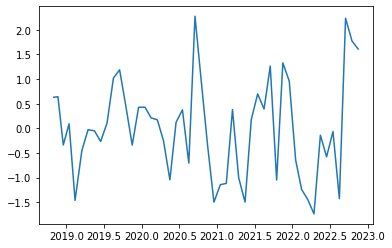

In [105]:
fig , ax = plt.subplots()
cmwe_ts.plot_anomalies(ax=ax)
precip_ts.coef_determination(fw_ts)
precip_ts.coef_determination(cmwe_ts)
fw_ts.coef_determination(precip_ts)
fw_ts.coef_determination(cmwe_ts)
cmwe_ts.coef_determination(precip_ts)
cmwe_ts.coef_determination(fw_ts);

## Scratchwork

In [ ]:
res_shp.loc[res_shp['MAIN_BASIN'] == 'Mekong',['DAM_NAME','COUNTRY','MAIN_USE','YEAR','CAP_MCM']].sort_values('CAP_MCM',ascending=False)